In [13]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind_from_stats
from tqdm.notebook import tqdm
from itertools import combinations

%matplotlib inline

### Схема подготовки датасета для анализа

1. генерим много переменных из логнормального распределения
2. собираем датасет вида: idx|metric_1|metric_2|...|metric_k размера N (где N - это количество наблюдений, k - количество переменных)
3. собираем датасет вида: idx|aa_1|aa_2|...|aa_r размера N (где r - количество АА-тестов). aa_i - это либо 0 либо 1
4. объединяем данные
5. для каждой метрики в рамках каждого теста считаем p_value
6. получаем датасет размерности r на k, где строки - это эксперименты, а столбцы - это метрики (значения - p_value)

In [2]:
# alpha
alpha = 0.05
# number of observations (users/devices/etc)
N = 10000
# number of metrics
k = 100
# number of experiments
r = 10000
# extra variables
metric_names = [f'metric_{i}' for i in range(k)]
aa_names = [f'aa_{i}' for i in range(r)]
# generate metrics
metrics = np.array([np.random.lognormal(mean=2, sigma=1.2, size=N) for _ in range(k)])
metrics_df = pd.DataFrame(metrics.T, 
                          columns=metric_names)
metrics_df['idx'] = range(N)
# generate experiments
experiments = np.array([np.random.uniform(size=N)<0.5 for _ in range(r)])
experiments_df = pd.DataFrame(experiments.T, 
                              columns=aa_names).astype('int8')
total_df = pd.concat([metrics_df, experiments_df], axis=1)
total_df.head(3)

,metric_0,metric_1,metric_2,metric_3,metric_4,metric_5,metric_6,metric_7,metric_8,metric_9,...,aa_9990,aa_9991,aa_9992,aa_9993,aa_9994,aa_9995,aa_9996,aa_9997,aa_9998,aa_9999
0,5.787032,7.440645,17.611127,7.107324,12.075991,1.763074,2.824533,2.908675,3.262085,6.376590,...,1,1,0,1,1,0,1,0,1,0
1,13.443296,28.555165,17.268139,21.570654,2.555099,12.033124,21.373145,9.127263,8.180356,17.283241,...,0,0,1,1,1,0,1,0,1,1
2,8.654246,3.280900,107.151225,2.374595,4.712428,14.382248,2.025379,19.653022,4.224421,0.331965,...,0,1,1,1,1,1,1,1,0,0


In [3]:
%%time
final_dataset = []
for exp_name in tqdm(aa_names):
    means = total_df.groupby([exp_name])[[f'metric_{i}' for i in range(k)]].mean().to_dict()
    stds = total_df.groupby([exp_name])[[f'metric_{i}' for i in range(k)]].std().to_dict()
    metrics_pvalues = []
    for metric in metric_names:
        mean1, mean2 = means[metric][0], means[metric][1]
        std1, std2 = stds[metric][0], stds[metric][1]
        p_value = ttest_ind_from_stats(mean1=mean1, 
                                       std1=std1, 
                                       nobs1=N//2, 
                                       mean2=mean2, 
                                       std2=std2, 
                                       nobs2=N//2).pvalue
        metrics_pvalues.append(p_value)
    final_dataset.append(metrics_pvalues)

  0%|          | 0/10000 [00:00<?, ?it/s]

Wall time: 7min 1s


In [4]:
pvalues_dataset = pd.DataFrame(final_dataset, columns=metric_names, index=aa_names)
pvalues_dataset.head(3)

,metric_0,metric_1,metric_2,metric_3,metric_4,metric_5,metric_6,metric_7,metric_8,metric_9,...,metric_90,metric_91,metric_92,metric_93,metric_94,metric_95,metric_96,metric_97,metric_98,metric_99
aa_0,0.129875,0.676878,0.430260,0.745017,0.520935,0.715475,0.378536,0.761607,0.644121,0.926832,...,0.55907,0.854065,0.826326,0.150207,0.561828,0.456922,0.583381,0.062629,0.122100,0.645073
aa_1,0.615254,0.344529,0.615083,0.377115,0.442897,0.821052,0.299991,0.390790,0.511310,0.839744,...,0.44356,0.224412,0.497389,0.702164,0.248041,0.042266,0.860932,0.961485,0.276302,0.722745
aa_2,0.390855,0.383696,0.668752,0.317577,0.784105,0.581177,0.319772,0.527526,0.488289,0.383543,...,0.42634,0.763184,0.662777,0.344226,0.832393,0.950588,0.483909,0.767998,0.460943,0.510996


In [46]:
# 
#results = []
#metric_combinations = [['metric_0', 'metric_1', 'metric_2', 'metric_3', 'metric_4'],
#                       ['metric_2', 'metric_3', 'metric_5', 'metric_6']]
#for metric_combination in metric_combinations:
#    comb_result = []
#    for min_number_significant in range(1, 6):
#        if min_number_significant<=len(metric_combination):
#            error = np.mean([sum(i<alpha)>=min_number_significant for i in pvalues_dataset[metric_combination].values])
#        else:
#            error = None
#        comb_result.append(error)
#    results.append(comb_result)
#errors_per_combination = pd.DataFrame(results, columns=[f'min_significant_{i}' for i in range(1, 6)])
#errors_per_combination

### meta p_value sceme

1. посчитаем для выбранной комбинации метрик средний p_value
2. построим распределение и найдем квантиль, равный alpha
3. будем использовать этот квантиль для расчета ошибки первого рода (запустим серию АА-тестов отдельно)

metrics: metric_0, metric_1, metric_2, metric_3, metric_4; threshold = 0.2905144403455091


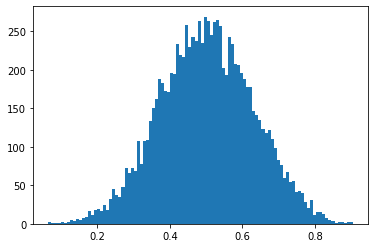

In [41]:
metric_combination = ['metric_0', 'metric_1', 'metric_2', 'metric_3', 'metric_4']
mean_pvalues = pvalues_dataset[metric_combination].mean(axis=1).values
# calc quantile
combination_quantile = np.quantile(mean_pvalues, alpha)
print(f'metrics: {", ".join(metric_combination)} threshold = {combination_quantile}')
plt.hist(mean_pvalues, bins=100)
plt.show()